# Football in Denmark: Where are we playing?

Imports and set magics:

In [1]:
# %pip install git+https://github.com/alemartinello/dstapi #Installing the API (only need to do once)

In [2]:
# %pip install pandas-datareader # Installing the data reader (only need to do once)

In [3]:
# %pip install geopandas 
# Installing the geopandas reader (only need to do once)

In [4]:
import pandas as pd
from IPython.display import Image
import numpy as np
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
import ipywidgets as widgets
# from matplotlib_venn import venn2
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Read data

Creating a dictionary for the columns names:

In [19]:
columns_dict = {}
columns_dict['BLSTKOM'] = 'region'
columns_dict['AKTIVITET'] = 'activity'
columns_dict['KON'] = 'sex'
columns_dict['ALDER1'] = 'age'
columns_dict['TID'] = 'year'
columns_dict['POP'] = 'population'
columns_dict['INDHOLD'] = 'players'

**Step 1:** Downloading all of the football-variables in merged_df01

In [6]:
idrakt_api = DstApi('IDRAKT01')  #Creating the DST API which will allow us to interact with the API server
params = idrakt_api._define_base_params(language='en') #Creating a parameter dictionary with the language set to English
variables = params['variables'] # Returns a view, that we can edit
variables[1]['values'] = ['A22'] # Choosing football as the activity (The ID for football is A22 Using code from: https://alemartinello.com/2022/02/24/dstapi/)
print(variables)

[{'code': 'BLSTKOM', 'values': ['*']}, {'code': 'AKTIVITET', 'values': ['A22']}, {'code': 'KON', 'values': ['*']}, {'code': 'ALDER1', 'values': ['*']}, {'code': 'Tid', 'values': ['*']}]


In [7]:
idrakt = idrakt_api.get_data(params=params) #Downloading the dataset

**Step 1A** Henter Befolkningsdata fra FOLK1AM

In [8]:
folk_api = DstApi('FOLK1A')  #Creating the DST API which will allow us to interact with the API server
params = folk_api._define_base_params(language='en') #Creating a parameter dictionary with the language set to English
variables = params['variables'] # Returns a view, that we can edit
variables[2]['values'] = ['IALT']
variables[3]['values'] = ['TOT']
print(variables)

[{'code': 'OMRÅDE', 'values': ['*']}, {'code': 'KØN', 'values': ['*']}, {'code': 'ALDER', 'values': ['IALT']}, {'code': 'CIVILSTAND', 'values': ['TOT']}, {'code': 'Tid', 'values': ['*']}]


In [9]:
folk = folk_api.get_data(params=params) #Downloading the dataset

# Clean data

**Cleaning population data (FOLK1A)**

In [10]:
folk.drop(columns=['ALDER', 'CIVILSTAND'], inplace=True)

In [11]:
folk_q1 = folk.loc[folk['TID'].str.contains('Q1')] # Selecting only the first quarter of the year
folk_q1['TID'] = folk_q1['TID'].str.replace('Q1', '')
folk_q1['KØN'] = folk_q1['KØN'].str.replace('Total', 'Sex, total')
folk_q1['OMRÅDE'] = folk_q1['OMRÅDE'].str.replace('Landsdel', 'Province')

# Define a list of the regions in the dataset
regions = ['All Denmark', 'Region Nordjylland', 'Region Midtjylland', 'Region Syddanmark', 'Region Sjælland', 'Region Hovedstaden']

# Filter the DataFrame to keep only rows where 'OMRÅDE' matches one of the regions
folk_q1 = folk_q1[folk_q1['OMRÅDE'].isin(regions)]
folk_q1.head()

C:\Users\rasmu\AppData\Local\Temp\ipykernel_17520\3082106661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  folk_q1['TID'] = folk_q1['TID'].str.replace('Q1', '')
C:\Users\rasmu\AppData\Local\Temp\ipykernel_17520\3082106661.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  folk_q1['KØN'] = folk_q1['KØN'].str.replace('Total', 'Sex, total')
C:\Users\rasmu\AppData\Local\Temp\ipykernel_17520\3082106661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,OMRÅDE,KØN,TID,INDHOLD
50,Region Sjælland,Men,2009,407228
56,Region Sjælland,"Sex, total",2009,821252
61,Region Sjælland,Women,2009,414024
262,Region Syddanmark,"Sex, total",2009,1199667
263,Region Syddanmark,Men,2009,597320


**Cleaning football data (IDRAKT01)**

**Step 2:** Only keep rows where the variable is in `Age, total` and afterwards deleting the coloumn.

In [12]:
#Only keeps rows with age = 'Age, total' and afterwards deleting the age coloumn
idrakt = idrakt[idrakt['ALDER1'] == 'Age, total']
idrakt.drop(columns=['ALDER1'],inplace=True)

In [13]:
unique_values = idrakt['BLSTKOM'].unique()
print(unique_values)

['Herning' 'Horsens' 'Hillerød' 'Holstebro' 'Lemvig' 'Vordingborg'
 'Odense' 'Kolding' 'Province Nordjylland' 'Vejle' 'Ballerup'
 'Høje-Taastrup' 'Lyngby-Taarbæk' 'Solrød' 'Province Byen København'
 'Province Bornholm' 'Roskilde' 'Slagelse' 'Sønderborg' 'Fredericia'
 'Province Københavns omegn' 'Province Nordsjælland'
 'Province Østsjælland' 'Svendborg' 'Esbjerg' 'Norddjurs' 'Hedensted'
 'Province Sydjylland' 'Brønderslev' 'Hjørring' 'Herlev' 'Hørsholm'
 'All Denmark' 'Province Østjylland' 'Stevns' 'Bornholm' 'Silkeborg'
 'Ikast-Brande' 'Rødovre' 'Rudersdal' 'Brøndby' 'Gribskov' 'Lolland'
 'Morsø' 'Favrskov' 'Frederiksberg' 'Albertslund' 'Lejre'
 'Ringkøbing-Skjern' 'Frederikshavn' 'Not stated' 'Sorø' 'Dragør' 'Tønder'
 'Middelfart' 'Nordfyns' 'Ishøj' 'Province Vestjylland' 'Gentofte' 'Fanø'
 'Odder' 'Egedal' 'Odsherred' 'Struer' 'Samsø' 'Tårnby' 'Skive' 'Gladsaxe'
 'Varde' 'Vallensbæk' 'Holbæk' 'Province Vest- og Sydsjælland'
 'Vesthimmerlands' 'Copenhagen' 'Frederikssund' 'Skanderbor

Summarizing provinces to regions:

In [14]:
def map_regions(BLSTKOM):
    if BLSTKOM == 'All Denmark':
        return 'All Denmark'
    elif BLSTKOM == 'Province Nordjylland':
        return 'Region Nordjylland'
    elif BLSTKOM in ['Province Vestjylland', 'Province Østjylland']:
        return 'Region Midtjylland'
    elif BLSTKOM in ['Province Fyn', 'Province Sydjylland']:
        return 'Region Syddanmark'
    elif BLSTKOM in ['Province Østsjælland', 'Province Vest- og Sydsjælland']:
        return 'Region Sjælland'
    elif BLSTKOM in ['Province Bornholm', 'Province Byen København', 'Province København omegn', 'Province Nordsjælland']:
        return 'Region Hovedstaden'
    else:
        return BLSTKOM  # Keep the original value for non-province entries

# Apply the function and update the 'BLSTKOM' column in place
idrakt['BLSTKOM'] = idrakt['BLSTKOM'].apply(map_regions)

Only keeping regions and all of Denmark

In [15]:
# Filter the DataFrame to keep only rows where 'BLSTKOM' matches one of the regions
idrakt = idrakt[idrakt['BLSTKOM'].isin(regions)]

# Display the first few rows to verify the filtering
idrakt.head()

,BLSTKOM,AKTIVITET,KON,TID,INDHOLD
180,Region Nordjylland,Football,Men,2019,30800
186,Region Nordjylland,Football,"Sex, total",2019,40140
192,Region Nordjylland,Football,Women,2019,9340
288,Region Hovedstaden,Football,Men,2017,43840
294,Region Hovedstaden,Football,"Sex, total",2017,49680


## Merging the two datasets and the sorting:

In [22]:
idrakt['TID'] = idrakt['TID'].astype(str)
folk_q1['TID'] = folk_q1['TID'].astype(str)

merged_df = pd.merge(
    idrakt,
    folk_q1.rename(columns={'INDHOLD': 'POP'}),  # Rename INDHOLD to POP in folk_q1 before merging
    how='left',  # Keep all rows from idrakt
    left_on=['BLSTKOM', 'KON', 'TID'],  # Columns to match in idrakt
    right_on=['OMRÅDE', 'KØN', 'TID']  # Corresponding columns to match in folk_q1
)
merged_df.drop(['OMRÅDE', 'KØN'], axis=1, inplace=True) #Drops unnessecary columns

# rename columns
merged_df.rename(columns=columns_dict,inplace=True)

# Display the first few rows to verify the merge
merged_df.head()

,region,activity,sex,year,players,population
0,Region Nordjylland,Football,Men,2019,30800,297879
1,Region Nordjylland,Football,"Sex, total",2019,40140,589755
2,Region Nordjylland,Football,Women,2019,9340,291876
3,Region Hovedstaden,Football,Men,2017,43840,887224
4,Region Hovedstaden,Football,"Sex, total",2017,49680,1807404


Sort the dataset by county, year and sex

In [29]:
# Sorting the dataset by county then year and then total sex, but first we customly sort the order of Sex
# Define a custom sorting order
sort_order = ['Sex, total', 'Men', 'Women']

# Create a categorical type with the custom order
merged_df['sex'] = pd.Categorical(merged_df['sex'], categories=sort_order, ordered=True)

merged_df.sort_values(by=['region','year','sex'],inplace=True)
merged_df.reset_index(drop=True,inplace=True)
merged_df.head()

,region,activity,sex,year,players,population
0,All Denmark,Football,"Sex, total",2014,374400,5627235
1,All Denmark,Football,Men,2014,307430,2792279
2,All Denmark,Football,Women,2014,66970,2834956
3,All Denmark,Football,"Sex, total",2015,372640,5659715
4,All Denmark,Football,Men,2015,306540,2811014


# Analysis across genders

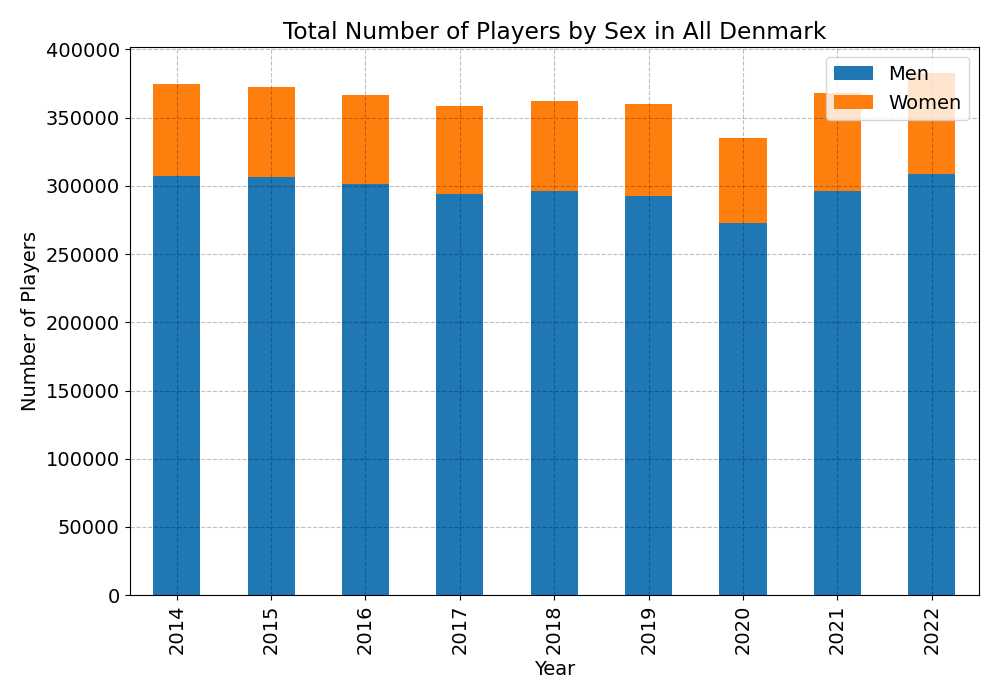

In [41]:
from dataproject import total_players_dk
total_players_dk(merged_df)
# Display the saved plot in the notebook
Image(filename='stacked_bar_chart.png')

Here we calculate the total number of Danish football players split based on sex. 

C:\Users\rasmu\AppData\Local\Temp\ipykernel_17520\2550836803.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_idrakt_stackedbar = idrakt_stackedbar.groupby(['year', 'sex'])['players'].sum().unstack()


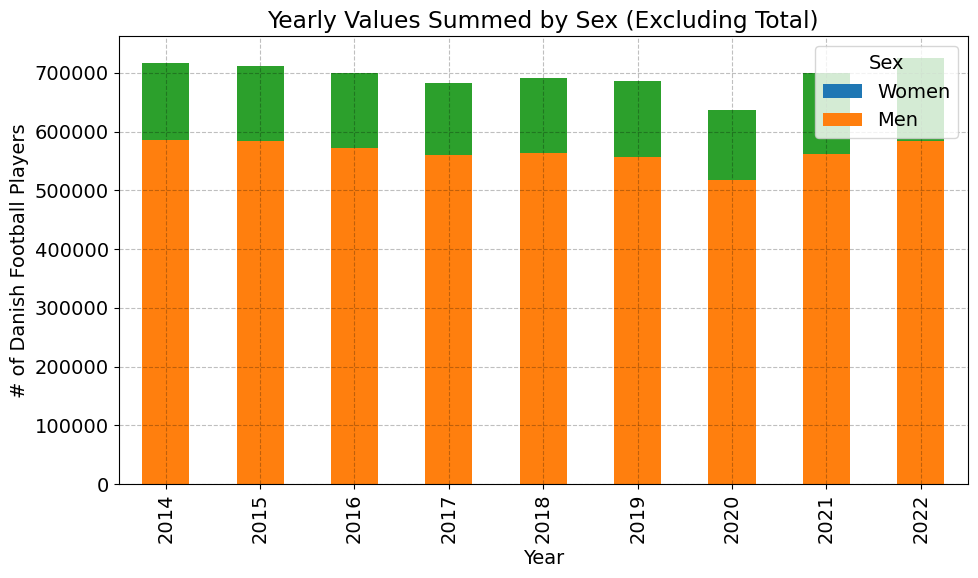

In [28]:
# Filtering out 'Sex, total' from the dataset
idrakt_stackedbar = merged_df[merged_df['sex'] != 'Sex, total']

# Grouping by 'year' and 'sex', then summing the values
grouped_idrakt_stackedbar = idrakt_stackedbar.groupby(['year', 'sex'])['players'].sum().unstack()

# Plotting the stacked bar chart
grouped_idrakt_stackedbar.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Yearly Values Summed by Sex (Excluding Total)')
plt.xlabel('Year')
plt.ylabel('# of Danish Football Players')
plt.legend(labels=['Women', 'Men'], title='Sex')
plt.tight_layout()
plt.show()

It is hard to see the relative development between the sexes and for total. Hence, we index the values and display here.

In [ ]:
index_values = idrakt_all[idrakt_all['year'] == 2014].set_index('sex')['value'] # Create a series with the 2014 values
indexed_idrakt_all = idrakt_all.set_index(['year', 'sex']) # Set the index
indexed_idrakt_all['indexed_value'] = 100*indexed_idrakt_all['value'] / indexed_idrakt_all['value'].unstack().loc[2014] # Calculate the indexed values

# Resetting index for plotting
indexed_idrakt_all = indexed_idrakt_all.reset_index() 

# Step 2: Plot the indexed values
plt.figure(figsize=(10, 6))
for sex, group in indexed_idrakt_all.groupby('sex'): # Loop over the groups
    plt.plot(group['year'], group['indexed_value'], marker='o', label=sex) 

plt.title('Relative Development Indexed to 2014 Values')
plt.xlabel('Year')
plt.ylabel('Index (2014 = 100)')
plt.legend()
plt.grid(True)
plt.show()

2018 women suddenly increases a lot towards 2019. The lockdown in 2020 is visuably for both sexes. However, afterwards, women footballers continues to increase with a much higher rate than men.

Annual growth contributions

In [ ]:
# Step 1: Calculate year-over-year change for each category
idrakt_all['year_over_year_change'] = idrakt_all.groupby('sex')['value'].diff()

# Step 2: Calculate the contribution for each category
# First, create a pivot for the total values to align with the changes data
total_values_previous_year = idrakt_all[idrakt_all['sex'] == 'Sex, total'][['year', 'value']].rename(columns={'value': 'total_previous_year'})
total_values_previous_year['year'] += 1  # Aligning total of year n-1 with year n

# Merge this back into the main DataFrame
idrakt_all = pd.merge(idrakt_all, total_values_previous_year, on='year', how='left')

# Now calculate the contributions
idrakt_all['contribution'] = idrakt_all.apply(lambda x: x['year_over_year_change'] / x['total_previous_year'] if x['sex'] != 'Sex, total' else None, axis=1)

# Step 3: Pivot the data for plotting
pivot_contribution = idrakt_all.pivot(index='year', columns='sex', values='contribution')

# Visualize the contributions
pivot_contribution[['Men', 'Women']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Growth Contributions from Men and Women')
plt.xlabel('Year')
plt.ylabel('Growth p.a. (%)')
plt.legend(['Men', 'Women'])
plt.show()

The figure above shows that even though women increases a lot, the contributions to the overall growth is fairly dominated by men because of the larger base. 

# Analysis across geography

Plotting the number of football players by county

In [ ]:
# Filter the DataFrame for 'Sex, total'
idrakt_sex_total = idrakt[idrakt['sex'] == 'Sex, total']

# Create a series with the 2014 values
index_values = idrakt_sex_total[idrakt_sex_total['year'] == 2014].set_index('county')['value']

# Set the index
indexed_idrakt = idrakt_sex_total.set_index(['year', 'county'])

# Calculate the indexed values
indexed_idrakt['indexed_value'] = 100*indexed_idrakt['value'] / indexed_idrakt['value'].unstack().loc[2014]

# Resetting index for plotting
indexed_idrakt = indexed_idrakt.reset_index()

# Plot the indexed values
plt.figure(figsize=(10, 6))
for county, group in indexed_idrakt.groupby('county'): # Loop over the groups
    plt.plot(group['year'], group['indexed_value'], marker='o', label=county)

plt.title('Relative Development Indexed to 2014 Values')
plt.xlabel('Year')
plt.ylabel('Index (2014 = 100)')
plt.legend()
plt.grid(True)
plt.show()

Because it is difficult to see what is going on, we make a plot, splitting into the broader county definition, county_b

In [ ]:
# Filter the DataFrame for 'Sex, total'
idrakt_sex_total_2 = idrakt[idrakt['sex'] == 'Sex, total']

# Pivot the DataFrame
pivot_table = idrakt_sex_total_2.pivot_table(index='year', columns='county_b', values='value', aggfunc='sum')

# Calculate indexed values relative to 2014
indexed_values = pivot_table.div(pivot_table.loc[2014]) * 100

# Plot the indexed values
plt.figure(figsize=(10, 6))
for county_b in indexed_values.columns:
    plt.plot(indexed_values.index, indexed_values[county_b], marker='o', label=county_b)

plt.title('Relative Development Indexed to 2014 Values')
plt.xlabel('Year')
plt.ylabel('Index (2014 = 100)')
plt.legend()
plt.grid(True)
plt.show()


Making a plot of the sexes across counties

In [ ]:
from dataproject import calculate_geographic_shares

# Assuming df is your DataFrame with football player data
geographic_shares = calculate_geographic_shares(idrakt)

import matplotlib.pyplot as plt

# Creating a bar plot
geographic_shares.plot(kind='bar', x='county', y='share')
plt.title('Share of Football Players by Geography')
plt.xlabel('Geography')
plt.ylabel('Share')
plt.show()


# Conclusion

ADD CONCISE CONLUSION.

We see that...